## Libraries & Imports

In [1]:
!pip install tf-nightly==2.6.0.dev20210501

     |████████████████████████████████| 456.8MB 37kB/s 
     |████████████████████████████████| 4.2MB 33.6MB/s 
     |████████████████████████████████| 5.5MB 26.7MB/s 
     |████████████████████████████████| 471kB 59.2MB/s 
     |████████████████████████████████| 1.3MB 41.5MB/s 
ERROR: tensorflow 2.5.0 has requirement grpcio~=1.34.0, but you'll have grpcio 1.38.1 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement keras-nightly~=2.5.0.dev, but you'll have keras-nightly 2.6.0.dev2021062500 which is incompatible.
  Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Found existing installation: keras-nightly 2.5.0.dev2021032900
    Uninstalling keras-nightly-2.5.0.dev2021032900:
      Successfully uninstalled keras-nightly-2.5.0.dev2021032900


In [2]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2782, done.
remote: Counting objects: 100% (2782/2782), done.
remote: Compressing objects: 100% (2317/2317), done.
remote: Total 2782 (delta 711), reused 1301 (delta 430), pack-reused 0
Receiving objects: 100% (2782/2782), 32.76 MiB | 29.38 MiB/s, done.
Resolving deltas: 100% (711/711), done.


In [3]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1658497 sha256=db071ce030333cb6e7479ee22481fac20b58887795cc1e3a6b62a0a707fd1594
  Stored in directory: /tmp/pip-ephem-wheel-cache-txsw7e2d/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.2-cp37-none-any.whl size=44011 sha256=64e654e477d04ef3ca3dae16292abdce2db0d560ce330328e27a0397f0185602
  Stored in directory: /root/.cache/pip/wheels/ee/ee/18/c466221ca6900e3efce2f4ea9c329288808679aecdcb2838d3
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78545 sha256=b8d9b5203f5463044ff296206a8792101b3be47ea26d8a9605ab027a4ecba903
  Stored in directory: /root/.cache/pip/wheels/59/b1/91/f02e76c732915c4015ab4010f3015469866c1eb9b14058d8e7
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=9e1e8671a346bfaf4b8b78e2f8948e69bc918375fcb927806ca1

ERROR: tf-nightly 2.6.0.dev20210501 has requirement keras-nightly~=2.6.0.dev, but you'll have keras-nightly 2.5.0.dev2021032900 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement grpcio~=1.34.0, but you'll have grpcio 1.38.1 which is incompatible.
ERROR: multiprocess 0.70.12.2 has requirement dill>=0.3.4, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.31.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.


In [4]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.utils import config_util
from object_detection.builders import model_builder

%matplotlib inline

## Utilities for Inference

The `detect` function shown below describes how input and output tensors from CenterNet (obtained in subsequent sections) can be processed. This logic can be ported to other languages depending on your application (for e.g. to Java for Android apps).

In [5]:
def detect(interpreter, input_tensor, include_keypoint=False):
  """Run detection on an input image.

  Args:
    interpreter: tf.lite.Interpreter
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.
    include_keypoint: True if model supports keypoints output. See
      https://cocodataset.org/#keypoints-2020

  Returns:
    A sequence containing the following output tensors:
      boxes: a numpy array of shape [N, 4]
      classes: a numpy array of shape [N]. Note that class indices are 
        1-based, and match the keys in the label map.
      scores: a numpy array of shape [N] or None.  If scores=None, then
        this function assumes that the boxes to be plotted are groundtruth
        boxes and plot all boxes as black with no classes or scores.
      category_index: a dict containing category dictionaries (each holding
        category index `id` and category name `name`) keyed by category 
        indices.
    If include_keypoints is True, the following are also returned:
      keypoints: (optional) a numpy array of shape [N, 17, 2] representing
        the yx-coordinates of the detection 17 COCO human keypoints
        (https://cocodataset.org/#keypoints-2020) in normalized image frame
        (i.e. [0.0, 1.0]). 
      keypoint_scores: (optional) a numpy array of shape [N, 17] representing the
        keypoint prediction confidence scores.
  """
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  interpreter.set_tensor(input_details[0]['index'], input_tensor.numpy())

  interpreter.invoke()

  boxes = interpreter.get_tensor(output_details[0]['index'])
  classes = interpreter.get_tensor(output_details[1]['index'])
  scores = interpreter.get_tensor(output_details[2]['index'])
  num_detections = interpreter.get_tensor(output_details[3]['index'])

  if include_keypoint:
    kpts = interpreter.get_tensor(output_details[4]['index'])
    kpts_scores = interpreter.get_tensor(output_details[5]['index'])
    return boxes, classes, scores, num_detections, kpts, kpts_scores
  else:
    return boxes, classes, scores, num_detections

# Utility for visualizing results
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    keypoints=None,
                    keypoint_scores=None,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    keypoints: (optional) a numpy array of shape [N, 17, 2] representing the 
      yx-coordinates of the detection 17 COCO human keypoints
      (https://cocodataset.org/#keypoints-2020) in normalized image frame
      (i.e. [0.0, 1.0]). 
    keypoint_scores: (optional) anumpy array of shape [N, 17] representing the
      keypoint prediction confidence scores.
    figsize: size for the figure.
    image_name: a name for the image file.
  """

  keypoint_edges = [(0, 1),
        (0, 2),
        (1, 3),
        (2, 4),
        (0, 5),
        (0, 6),
        (5, 7),
        (7, 9),
        (6, 8),
        (8, 10),
        (5, 6),
        (5, 11),
        (6, 12),
        (11, 12),
        (11, 13),
        (13, 15),
        (12, 14),
        (14, 16)]
  image_np_with_annotations = image_np.copy()
  # Only visualize objects that get a score > 0.3.
  print(classes)
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=keypoint_edges,
      use_normalized_coordinates=True,
      min_score_thresh=0.3)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    return image_np_with_annotations

# Object Detection

## Download Model from Detection Zoo

**NOTE:** Not all CenterNet models from the [TF2 Detection Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md) work with TFLite, only the [MobileNet-based version](http://download.tensorflow.org/models/object_detection/tf2/20210210/centernet_mobilenetv2fpn_512x512_coco17_od.tar.gz) does.


In [6]:
# Get mobile-friendly CenterNet for Object Detection
# See TensorFlow 2 Detection Model Zoo for more details:
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

%%bash
wget http://download.tensorflow.org/models/object_detection/tf2/20210210/centernet_mobilenetv2fpn_512x512_coco17_od.tar.gz
tar -xf centernet_mobilenetv2fpn_512x512_coco17_od.tar.gz
rm centernet_mobilenetv2fpn_512x512_coco17_od.tar.gz*

--2021-07-12 15:38:59--  http://download.tensorflow.org/models/object_detection/tf2/20210210/centernet_mobilenetv2fpn_512x512_coco17_od.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.2.128, 2607:f8b0:4023:c0d::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.2.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44016454 (42M) [application/x-tar]
Saving to: ‘centernet_mobilenetv2fpn_512x512_coco17_od.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  121M 0s
    50K .......... .......... .......... .......... ..........  0%  157M 0s
   100K .......... .......... .......... .......... ..........  0%  198M 0s
   150K .......... .......... .......... .......... ..........  0%  175M 0s
   200K .......... .......... .......... .......... ..........  0%  134M 0s
   250K .......... .......... .......... .......... ..........  0%  194M 0s
   300K .......... .......... .......... .........

Now that we have downloaded the CenterNet model that uses MobileNet as a backbone, we can obtain a TensorFlow Lite model from it. 

The downloaded archive already contains `model.tflite` that works with TensorFlow Lite, but we re-generate the model in the next sub-section to account for cases where you might re-train the model on your own dataset (with corresponding changes to `pipeline.config` & `checkpoint` directory).

## Generate TensorFlow Lite Model

First, we invoke `export_tflite_graph_tf2.py` to generate a TFLite-friendly intermediate SavedModel. This will then be passed to the TensorFlow Lite Converter for generating the final model.

This is similar to what we do for [SSD architectures](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_on_mobile_tf2.md).

In [7]:
%%bash
# Export the intermediate SavedModel that outputs 10 detections & takes in an 
# image of dim 320x320.
# Modify these parameters according to your needs.

python models/research/object_detection/export_tflite_graph_tf2.py \
  --pipeline_config_path=centernet_mobilenetv2_fpn_od/pipeline.config \
  --trained_checkpoint_dir=centernet_mobilenetv2_fpn_od/checkpoint \
  --output_directory=centernet_mobilenetv2_fpn_od/tflite \
  --centernet_include_keypoints=false \
  --max_detections=10 \
  --config_override=" \
    model{ \
      center_net { \
        image_resizer { \
          fixed_shape_resizer { \
            height: 320 \
            width: 320 \
          } \
        } \
      } \
    }"

9412608/9406464 [==============================] - 0s 0us/step


W0712 15:39:03.109593 139810886170496 mobilenet_v2.py:296] `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
2021-07-12 15:39:03.166763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-12 15:39:03.435234: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-07-12 15:39:03.452082: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1765] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to down

In [8]:
# Generate TensorFlow Lite model using the converter.
%%bash
tflite_convert --output_file=centernet_mobilenetv2_fpn_od/model.tflite \
  --saved_model_dir=centernet_mobilenetv2_fpn_od/tflite/saved_model

2021-07-12 15:39:49.885928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-12 15:39:49.891374: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-07-12 15:39:49.892116: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1765] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-07-12 15:39:49.892393: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized wit

## TensorFlow Lite Inference

Use a TensorFlow Lite Interpreter to detect objects in the test image.

In [9]:
!wget https://townsquare.media/site/397/files/2017/07/dashcam-video.jpg?w=1200&h=0&zc=1&s=0&a=t&q=89

--2021-07-12 15:40:06--  https://townsquare.media/site/397/files/2017/07/dashcam-video.jpg?w=1200
Resolving townsquare.media (townsquare.media)... 192.229.163.86
Connecting to townsquare.media (townsquare.media)|192.229.163.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119331 (117K) [image/jpeg]
Saving to: ‘dashcam-video.jpg?w=1200’

dashcam-video.jpg?w 100%[===================>] 116.53K  --.-KB/s    in 0.03s   

2021-07-12 15:40:06 (4.24 MB/s) - ‘dashcam-video.jpg?w=1200’ saved [119331/119331]



In [10]:
mv 'dashcam-video.jpg?w=1200' image2.jpg

In [11]:
!ls

centernet_mobilenetv2_fpn_od  image2.jpg  models  sample_data


[[[0.05289786 0.4905079  0.15924278 0.52891314]
  [0.5098919  0.17728144 0.75220007 0.3831238 ]
  [0.43284756 0.40383825 0.7255556  0.57859707]
  [0.44046423 0.5701708  0.675679   0.7135255 ]
  [0.35003152 0.7023825  0.38648015 0.7182204 ]
  [0.45101553 0.7277875  0.5110514  0.8836873 ]
  [0.260453   0.3217531  0.3116161  0.33653054]
  [0.45361024 0.80204433 0.50668985 0.88288254]
  [0.44046423 0.5701708  0.675679   0.7135255 ]
  [0.47912303 0.20736198 0.5311406  0.23450528]]] [[9. 7. 7. 7. 9. 2. 9. 2. 5. 0.]]
9
7
7
7
9
2
9
2
5
0
[1, 2, 3, 8]
[8 8 8 6]


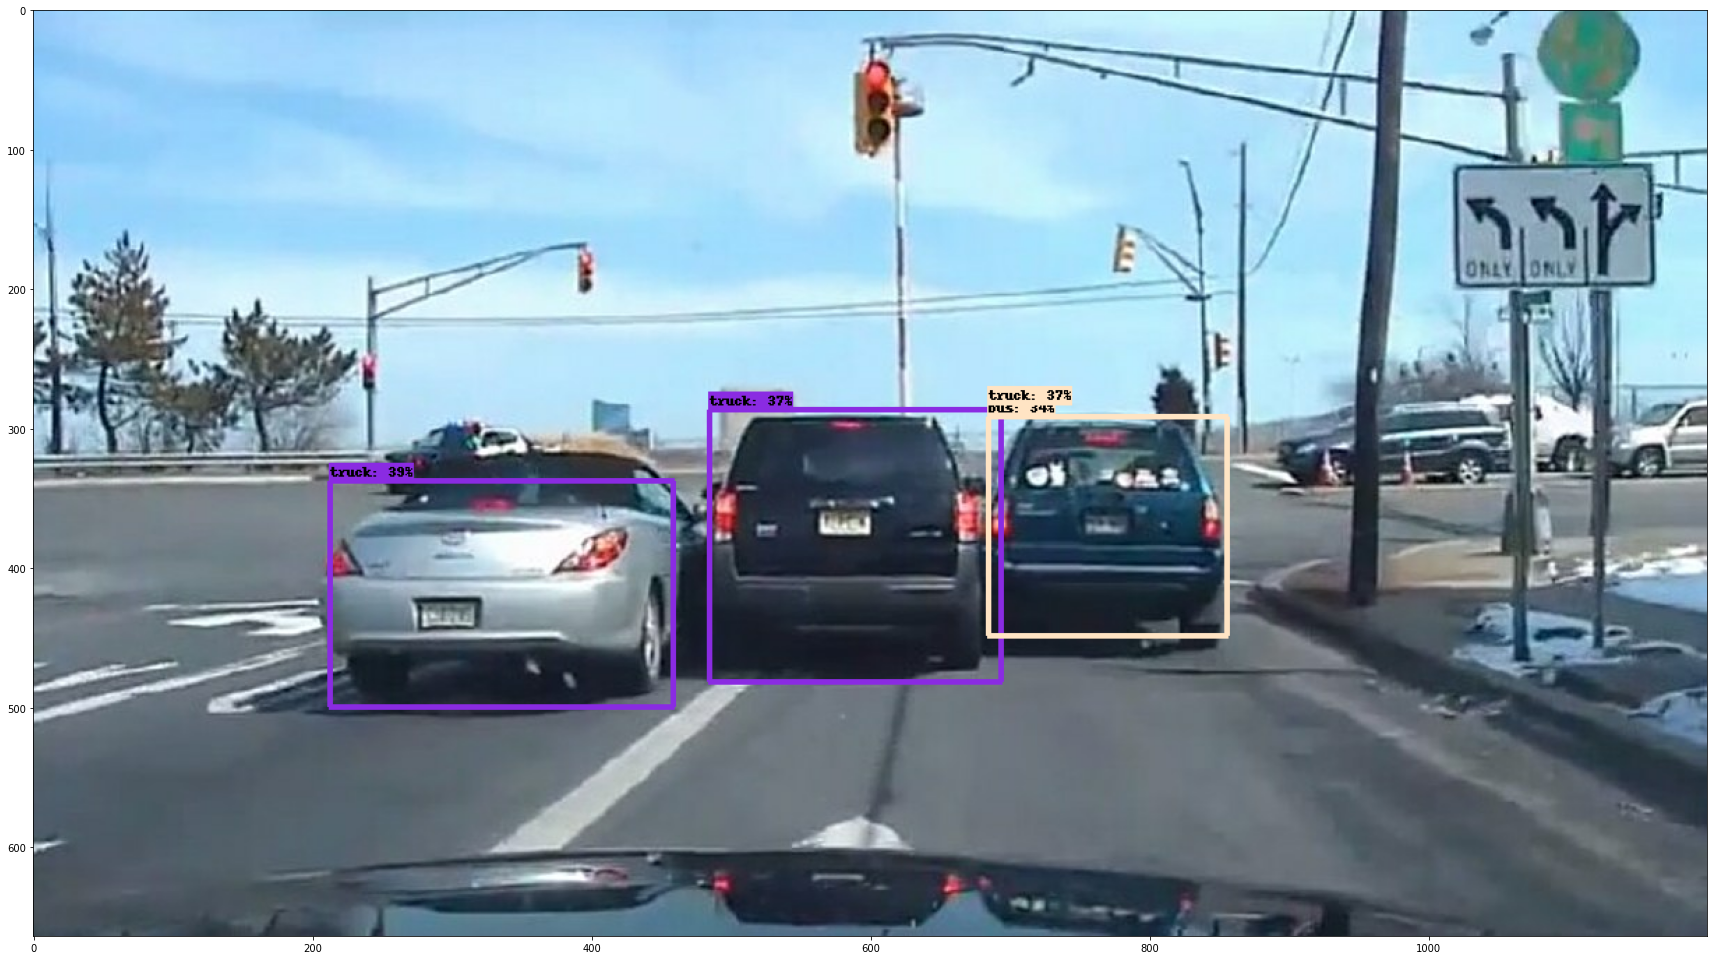

In [49]:
%matplotlib inline

# Load the TFLite model and allocate tensors.
model_path = 'centernet_mobilenetv2_fpn_od/model.tflite'
label_map_path = 'centernet_mobilenetv2_fpn_od/label_map.txt'
image_path = 'coco/val2017/000000013729.jpg'
image_path = 'image.jpg'
image_path = 'image2.jpg'

# Initialize TensorFlow Lite Interpreter.
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Label map can be used to figure out what class ID maps to what
# label. `label_map.txt` is human-readable.
category_index = label_map_util.create_category_index_from_labelmap(
    label_map_path)

label_id_offset = 1

image = tf.io.read_file(image_path)
image = tf.compat.v1.image.decode_jpeg(image)
image = tf.expand_dims(image, axis=0)
image_numpy = image.numpy()

input_tensor = tf.convert_to_tensor(image_numpy, dtype=tf.float32)
# Note that CenterNet doesn't require any pre-processing except resizing to the
# input size that the TensorFlow Lite Interpreter was generated with.
input_tensor = tf.image.resize(input_tensor, (320, 320))
boxes, classes, scores, num_detections = detect(interpreter, input_tensor)
boxes, classes, scores, num_detections = boxes[:4], classes[:4], scores[:4], num_detections[:4]
print(boxes, classes)

#filter cars and trucks and buses only, and filter by fov
indices = [2,5,7]
fov_left = 0.15
fov_right = 0.8

# keep_boxes = []
# keep_labels = []
# for i, label in classes[0].tolist():
#   if label in indices:
#     keep_boxes.append(boxes[0][i])
#     keep_labels.append(label)
# print(keep_boxes, keep_labels)
x = classes[0].astype(np.uint32)
#keep = boxes[0][boxes[0] ==2.]
keep_classes = np.fromiter((y for y in x if y in indices), dtype=x.dtype)
keep_indices = []
for i,label in enumerate(x):
  print(label)
  if label in indices:
    if (boxes[0][i][1] > fov_left) and (boxes[0][i][3] < fov_right):
      keep_indices.append(i)

keep_classes = x[keep_indices]
keep_boxes = boxes[0][keep_indices]
print(keep_indices)

vis_image = plot_detections(
    image_numpy[0],
    keep_boxes,
    keep_classes + label_id_offset,
    scores[0],
    category_index)
plt.figure(figsize = (30, 20))
plt.imshow(vis_image)

## Generate TensorFlow Lite Model

As before, we leverage `export_tflite_graph_tf2.py` to generate a TFLite-friendly intermediate SavedModel. This will then be passed to the TFLite converter to generating the final model.

Note that we need to include an additional `keypoint_label_map_path` parameter for exporting the keypoints outputs.

In [13]:
%%bash
# Export the intermediate SavedModel that outputs 10 detections & takes in an 
# image of dim 320x320.
# Modify these parameters according to your needs.

python models/research/object_detection/export_tflite_graph_tf2.py \
  --pipeline_config_path=centernet_mobilenetv2_fpn_kpts/pipeline.config \
  --trained_checkpoint_dir=centernet_mobilenetv2_fpn_kpts/checkpoint \
  --output_directory=centernet_mobilenetv2_fpn_kpts/tflite \
  --centernet_include_keypoints=true \
  --keypoint_label_map_path=centernet_mobilenetv2_fpn_kpts/label_map.txt \
  --max_detections=10 \
  --config_override=" \
    model{ \
      center_net { \
        image_resizer { \
          fixed_shape_resizer { \
            height: 320 \
            width: 320 \
          } \
        } \
      } \
    }"

Traceback (most recent call last):
  File "models/research/object_detection/export_tflite_graph_tf2.py", line 161, in <module>
    app.run(main)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 303, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 251, in _run_main
    sys.exit(main(argv))
  File "models/research/object_detection/export_tflite_graph_tf2.py", line 149, in main
    text_format.Parse(f.read(), pipeline_config)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/lib/io/file_io.py", line 117, in read
    self._preread_check()
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/lib/io/file_io.py", line 80, in _preread_check
    compat.path_to_str(self.__name), 1024 * 512)
tensorflow.python.framework.errors_impl.NotFoundError: centernet_mobilenetv2_fpn_kpts/pipeline.config; No such file or directory


In [14]:
# Generate TensorFlow Lite model using the converter.

%%bash
tflite_convert --output_file=centernet_mobilenetv2_fpn_kpts/model.tflite \
  --saved_model_dir=centernet_mobilenetv2_fpn_kpts/tflite/saved_model

Traceback (most recent call last):
  File "/usr/local/bin/tflite_convert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/tflite_convert.py", line 697, in main
    app.run(main=run_main, argv=sys.argv[:1])
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 303, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 251, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/tflite_convert.py", line 680, in run_main
    _convert_tf2_model(tflite_flags)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/tflite_convert.py", line 284, in _convert_tf2_model
    tags=_parse_set(flags.saved_model_tag_set))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/lite.py", line 1287, in from_saved_model
    saved_model = _load(saved_model_dir, tags)
  File "/usr/local/lib/python3.7/dist-pa

## TensorFlow Lite Inference

Use a TensorFlow Lite Interpreter to detect people & their keypoints in the test image.

In [15]:
%matplotlib inline

# Load the TFLite model and allocate tensors.
model_path = 'centernet_mobilenetv2_fpn_kpts/model.tflite'
image_path = 'coco/val2017/000000013729.jpg'

# Initialize TensorFlow Lite Interpreter.
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Keypoints are only relevant for people, so we only care about that
# category Id here.
category_index = {1: {'id': 1, 'name': 'person'}}

label_id_offset = 1

image = tf.io.read_file(image_path)
image = tf.compat.v1.image.decode_jpeg(image)
image = tf.expand_dims(image, axis=0)
image_numpy = image.numpy()

input_tensor = tf.convert_to_tensor(image_numpy, dtype=tf.float32)
# Note that CenterNet doesn't require any pre-processing except resizing to
# input size that the TensorFlow Lite Interpreter was generated with.
input_tensor = tf.image.resize(input_tensor, (320, 320))
(boxes, classes, scores, num_detections, kpts, kpts_scores) = detect(
    interpreter, input_tensor, include_keypoint=True)

vis_image = plot_detections(
    image_numpy[0],
    boxes[0],
    classes[0].astype(np.uint32) + label_id_offset,
    scores[0],
    category_index,
    keypoints=kpts[0],
    keypoint_scores=kpts_scores[0])
plt.figure(figsize = (30, 20))
plt.imshow(vis_image)

ValueError: ignored

# Running On Mobile

As mentioned earlier, both the above models can be run on mobile phones with TensorFlow Lite. See our [**inference documentation**](https://www.tensorflow.org/lite/guide/inference) for general guidelines on platform-specific APIs & leveraging hardware acceleration. Both the object-detection & keypoint-detection versions of CenterNet are compatible with our [GPU delegate](https://www.tensorflow.org/lite/performance/gpu). *We are working on developing quantized versions of this model.*

To leverage *object-detection* in your Android app, the simplest way is to use TFLite's [**ObjectDetector Task API**](https://www.tensorflow.org/lite/inference_with_metadata/task_library/object_detector). It is a high-level API that encapsulates complex but common image processing and post processing logic. Inference can be done in 5 lines of code. It is supported in Java for Android and C++ for native code. *We are working on building the Swift API for iOS, as well as the support for the keypoint-detection model.*

To use the Task API, the model needs to be packed with [TFLite Metadata](https://www.tensorflow.org/lite/convert/metadata). This metadata helps the inference code perform the correct pre & post processing as required by the model. Use the following code to create the metadata.

In [ ]:
!pip install tflite_support_nightly

In [ ]:
from tflite_support.metadata_writers import object_detector
from tflite_support.metadata_writers import writer_utils

ObjectDetectorWriter = object_detector.MetadataWriter

_MODEL_PATH = "centernet_mobilenetv2_fpn_od/model.tflite"
_SAVE_TO_PATH = "centernet_mobilenetv2_fpn_od/model_with_metadata.tflite"
_LABEL_PATH = "centernet_mobilenetv2_fpn_od/tflite_label_map.txt"

# We need to convert Detection API's labelmap into what the Task API needs:
# a txt file with one class name on each line from index 0 to N.
# The first '0' class indicates the background.
# This code assumes COCO detection which has 90 classes, you can write a label
# map file for your model if re-trained.
od_label_map_path = 'centernet_mobilenetv2_fpn_od/label_map.txt'
category_index = label_map_util.create_category_index_from_labelmap(
    label_map_path)
f = open(_LABEL_PATH, 'w')
for class_id in range(1, 91):
  if class_id not in category_index:
    f.write('???\n')
    continue
  name = category_index[class_id]['name']
  f.write(name+'\n')
f.close()

writer = ObjectDetectorWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), input_norm_mean=[0], 
    input_norm_std=[1], label_file_paths=[_LABEL_PATH])
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

Visualize the metadata just created by the following code:

In [ ]:
from tflite_support import metadata

displayer = metadata.MetadataDisplayer.with_model_file(_SAVE_TO_PATH)
print("Metadata populated:")
print(displayer.get_metadata_json())
print("=============================")
print("Associated file(s) populated:")
print(displayer.get_packed_associated_file_list())

See more information about *object-detection* models from our [public documentation](https://www.tensorflow.org/lite/examples/object_detection/overview). The [Object Detection example app](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection) is a good starting point for integrating that model into your Android and iOS app. You can find [examples](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/android#switch-between-inference-solutions-task-library-vs-tflite-interpreter) of using both the TFLite Task Library and TFLite Interpreter API.